Import libraries

In [92]:
import pandas as pd
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np
from catboost import Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Exploratory Analysis

ETL

In [93]:
def preprocess_data(data):
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])
    return data

In [94]:
train = pd.read_csv("train.csv", index_col=0)
train = preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [95]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

len(X_test), len(y_test)

(418, 418)

In [96]:
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([0, 1, 3, 4, 6, 7, 8], dtype=int64)

In [97]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,0
3,3,1,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,3,0,35.0,0,0,8.0500,0,0,1


In [98]:
# rebalance the dataset


Create a Model

In [99]:
# fit the model
model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
accuracy # 0.7990430622009569

0.7990430622009569

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       260
           1       0.77      0.66      0.71       158

    accuracy                           0.80       418
   macro avg       0.79      0.77      0.78       418
weighted avg       0.80      0.80      0.80       418



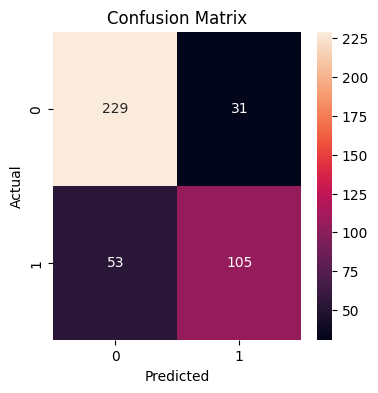

In [101]:
plt.figure(figsize = (4,4))
cm = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True)
cm.set(title='Confusion Matrix')
cm.set(xlabel='Predicted', ylabel='Actual')
plt.show()

Hyperparameter Tuning

We are going to find the best parameters for the model using GridSearchCV. Also, we are going to use Cross Validation to avoid overfitting.

In [102]:
'''
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    random_state=42)

params = {'depth': [2,3,4,5,6,7,8,9,10]}

'''
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
}
'''

grid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)

best_model = CatBoostClassifier(depth=grid['params']['depth'],
                                loss_function='Logloss',
                                eval_metric='Accuracy',
                                use_best_model=True,
                                random_seed=42,
                                verbose=False)

best_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))

accuracy_score(y_test, best_model.predict(X_test))
'''

"\n\ngrid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)\n\nbest_model = CatBoostClassifier(depth=grid['params']['depth'],\n                                loss_function='Logloss',\n                                eval_metric='Accuracy',\n                                use_best_model=True,\n                                random_seed=42,\n                                verbose=False)\n\nbest_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))\n\naccuracy_score(y_test, best_model.predict(X_test))\n"